Q4. ​Dataset​: Labeled Faces in the Wild, [​Link​ for dataset] ​[50 Marks + 10 Marks Bonus]
You need to perform binary classification for a person wearing ‘sunglasses’/’Eyeglasses’ in the dataset. There are number of attributes present for LFW dataset(please refer the link for details about the attributes labeling).[​Link​ for attributes]
● Separate the dataset into 2 files. 65% and 35% of the total dataset.
● For 65% dataset, perform binary classification for the person wearing ‘sunglasses’ /’Eyeglasses’
or not. [​Note​: In the dataset, eyeglasses and sunglasses are treated as different entities, you need
to consider them as single entity]
● UseDenseLayerModel:[128--128--128--64--1]
 
● Keep the loss function as the “mean square error”.
● Do you think there is any kind of bias in the system? Evaluate the system using 3 different
evaluation metrics to see if there is any bias or not. [10 Marks]
● Come up with a new evaluation metric to detect if there is a bias in the system.
[ Bonus 10 Marks]
● If you observed any bias in the system, mitigate the bias by: [30 Marks]
○ DATA method (Training using more data): You may use more data for training from that
35% data. Report the accuracy after mitigation and compare it with previous
classification results.
○ ALGORITHMIC method: Alter loss function to incorporate more challenges. Use a
multi-tasking approach to achieve your aim.Report the accuracy after mitigation and compare it with previous classification results.

dataset link: http://vis-www.cs.umass.edu/lfw/

attributes link: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt

In [1]:

import numpy as np
import os
import cv2
import pandas as pd
import tarfile
import tqdm

# Google Drive access
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/LFW
!pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/LFW
/content/gdrive/My Drive/LFW


In [2]:
# Dumping files to drive
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2020-12-29 07:07:28--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2020-12-29 07:07:28--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt.8’

lfw_attributes.txt. 100%[===================>]  14.19M  16.8MB/s    in 0.8s    

2020-12-29 07:07:29 (16.8 MB/s) - ‘lfw_attributes.txt.8’ saved [14879205/14879205]

--2020-12-29 07:07:29--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www

In [20]:
# File handlers
attributes = "lfw_attributes.txt"
images = "lfw.tgz"

In [21]:
# ref: https://colab.research.google.com/github/MalihaUCF/Autoencoders/blob/master/Autoencoder_PCA1.ipynb#scrollTo=C0miIeXh9dy1&line=28&uniqifier=1

def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_lfw_dataset(
        use_raw=True,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # read attrs
    df_attrs = pd.read_csv(attributes, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(images) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            if m.isfile() and m.name.endswith(".jpg"):
                # prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                # parse person
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



X shape: (13143, 38, 38, 3)
attr shape: (13143, 73)


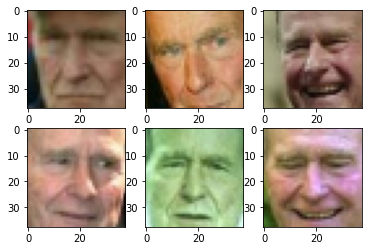

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
#from lfw_dataset import load_lfw_dataset
import tensorflow as tf
import keras, keras.layers as L

# Loading and normalizing [Might take some time]
X, attributes = load_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 255.0
img_shape = X.shape[1:]
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)
# Checking out some images
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = False
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])
print("X shape:",X.shape)
print("attr shape:",attributes.shape)

In [23]:
# lets divide the dataset into 65% and 35%

In [24]:
X_95 = np.round(0.95*len(X))

In [25]:
X_95

12486.0

In [26]:
attributes.Eyeglasses.iloc[0]
attributes['Eyeglasses_Sunglasses'] = 0
for i in range(len(attributes)):
  # to consider Eyeglasses and Sunglases as same quantity, let us take average of both and add it to the dataframe
  if(np.sign(attributes.Eyeglasses.iloc[i])==1 or np.sign(attributes.Sunglasses.iloc[i])==1):
    attributes['Eyeglasses_Sunglasses'].iloc[i] = 1
  else:
    attributes['Eyeglasses_Sunglasses'].iloc[i] = 0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [27]:
attributes.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace,Eyeglasses_Sunglasses
0,-0.602662,-0.83636,0.909554,-2.03901,-0.937008,-0.520853,-0.399348,-0.609662,-0.328941,-1.20055,-0.39051,-2.73407,-1.51945,0.555006,-0.625682,-1.45926,-0.866737,-0.396046,0.551072,-0.986439,-0.0734218,-0.564658,-1.16134,1.57563,0.965746,-0.607315,0.44931,0.668191,-0.405056,-0.613886,-0.167452,-2.5441,-0.58652,0.460766,0.00928555,-0.830431,1.97026,0.488666,-0.0477713,0.303884,-1.35427,0.930372,-1.71259,-0.298748,0.465369,0.794791,-0.450567,0.283735,-0.148479,1.27906,0.959224,-0.7095,-0.684215,2.31964,-0.858775,0.0266835,-0.929809,-1.79466,0.094929,-0.56723,-1.07044,-1.52884,-1.4068,-0.793891,-1.77256,0.234426,-0.531727,-2.35169,0.0929558,1.51383,-0.176601,-0.335991,-0.882286,0
1,0.505597,-1.91405,2.51025,-2.4314,-1.00337,-1.44539,-1.537,-0.204474,0.487091,-1.74747,-0.311364,-0.0631772,-0.957594,0.501207,0.221517,-1.75726,-0.551377,-0.282309,0.195253,-0.317791,-0.912739,-0.614058,0.64591,0.481944,-1.51933,0.566179,0.801907,-1.0607,0.901279,-1.34742,0.0797163,0.268679,-0.467019,-1.30433,-0.991695,-0.0503162,0.261866,0.334746,0.785039,1.26984,-1.25441,1.10048,-0.924761,-1.37896,0.800159,0.343087,0.276153,0.115633,0.761935,-0.668475,0.721088,-0.480292,-1.00298,3.99115,-0.345703,0.0431644,-1.38426,-1.93805,0.39326,-0.749561,-0.329255,-0.579444,-0.234069,0.0096608,-0.374216,-0.0136298,-0.0809645,-2.12532,0.281169,-1.24167,-0.515579,0.1815,-0.80375,1
2,1.4038,-1.39616,0.636715,-1.02491,-1.76605,-0.661043,-1.73453,-0.239029,0.350139,-1.67061,-0.239739,-1.02587,-0.669365,0.294301,-0.243044,-1.24041,-0.559538,0.900781,-0.864989,0.925484,-0.415565,0.477309,-0.963641,0.498012,0.737615,1.38272,-0.318062,-0.137686,0.824265,-0.209637,-0.138066,0.0272288,-0.4622,-0.283984,-0.0591731,-0.364826,1.32351,0.275434,1.30362,-0.126634,-0.596104,-0.337977,-0.486416,0.0556214,-0.177267,0.375264,-0.448152,0.211282,0.64118,-1.23075,-1.00435,-0.264218,-0.173436,0.983262,-1.02405,-0.968107,-1.25158,-0.831154,-0.0487521,1.87388,-1.28517,0.366453,-0.517039,1.11466,-0.503967,1.65218,-1.14525,-1.25307,0.874682,0.497179,-1.11823,0.719109,-0.163028,0
3,0.929768,-1.75116,2.34706,-2.24259,-1.35852,-0.902918,-1.87211,-0.348193,0.106553,-1.92001,-0.843878,-1.45527,0.116413,-0.00884933,0.0968053,-1.77056,-0.883169,0.251477,-0.222816,0.979753,-0.485323,-1.15441,-0.31113,-0.157736,-0.350956,0.950488,0.347889,-1.20252,1.60015,-0.130796,-0.173291,-0.149002,-0.510854,-0.382419,-1.09431,-0.205277,0.963489,0.853781,0.156086,0.312227,-1.82151,0.594445,-0.243877,-1.54746,0.0892587,0.294815,-0.338663,0.0352336,1.02599,-0.407141,-0.64235,-0.298058,-0.607125,2.074,-0.076147,-0.79068,-1.32389,-1.5935,0.405241,0.768172,-1.27286,-1.30234,-0.816332,1.7813,-1.03106,0.705507,-1.68246,0.0304102,0.303866,-0.996759,-0.562108,1.39505,-0.601105,1
4,1.38212,-1.83819,1.63398,-1.49223,-1.35611,-0.560854,-1.68384,-0.825507,0.886115,-0.712738,-0.661126,-1.24526,-0.791411,1.20355,0.0238365,-0.901334,-0.807165,-1.22825,1.55971,0.280109,-1.60343,0.0921409,-0.770683,1.2718,0.0497857,0.109589,-0.910338,-1.046,-0.14786,-0.723328,-0.1958,0.970945,0.0858819,-1.36246,-0.221446,-1.39699,2.25194,0.369097,0.498237,0.365376,-1.9362

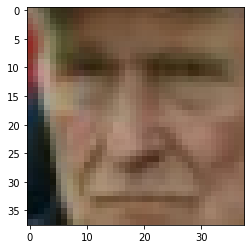

In [28]:
import matplotlib.pyplot as plt
plt.imshow(X[0])

Xtrain and Ytrain

Xtest and Ytest

# Start from here : The mitigation part. Taking 95% data as training

In [139]:
X_train_95 = X[0:12486]
len(X_train_95)

X_train_95 = X_train_95[0:12486]
X_test_95 = X[12486:13143]

print(len(X_train_95))
print(len(X_test_95))

Xtrain = X_train_95
Xtest = X_test_95
Ydata = np.array(attributes.Eyeglasses_Sunglasses)
print(len(Ydata))
print(Ydata)
Y_95 = Ydata[0:13143]
Y_train_95 = Y_95[0:12486] # Taking 80% data
Y_test_95 = Y_95[12486:13143]
print(len(Y_train_95))
print(len(Y_test_95))
Ytrain = Y_train_95
Ytest = Y_test_95


12486
657
13143
[0 1 0 ... 0 0 0]
12486
657


In [140]:
Xtrain = Xtrain[:,:,:,0]
Xtest = Xtest[:,:,:,0]
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(12486, 38, 38)
(12486,)
(657, 38, 38)
(657,)


In [141]:
print(type(Xtrain))
print(type(Ytrain))
print(type(Xtest))
print(type(Ytest))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [142]:
Xtrain = Xtrain.reshape(12486,38*38)
Xtest = Xtest.reshape(657,38*38)
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(12486, 1444)
(12486,)
(657, 1444)
(657,)


In [143]:
from skimage import data
from skimage.color import rgb2gray
Xtrain_rgb2grey = rgb2gray(Xtrain)
Xtest_rgb2grey = rgb2gray(Xtest)
print(Xtrain_rgb2grey.shape)
print(Ytrain.shape)
print(Xtest_rgb2grey.shape)
print(Ytest.shape)

(12486, 1444)
(12486,)
(657, 1444)
(657,)


In [163]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
# ann = models.Sequential([

#         layers.Dense(128, activation='relu'),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(1, activation='sigmoid')    
#     ])


input_layer = Input(shape=1444)
d1 = Dense(128, activation='relu')(input_layer)
d2 = Dense(128, activation='relu')(d1)
d3 = Dense(128, activation='relu')(d2)
d4 = Dense(64, activation='relu')(d3)
d5_1 = Dense(1, activation='relu',name='op1')(d4)
d5_2 = Dense(1, activation='relu',name='op2')(d4)
model = Model(inputs=input_layer,outputs=[d5_1, d5_2])


ann.compile(optimizer='SGD',loss=[{'op1': 'binary_crossentropy', 'op2': 'mean_squared_error'}], metrics=['accuracy'])



ann.fit(Xtrain, Ytrain, epochs=20)



Epoch 1/20
391/391 [==============================] - 2s 3ms/step - loss: 0.3776 - accuracy: 0.8388
Epoch 2/20
391/391 [==============================] - 1s 3ms/step - loss: 0.3774 - accuracy: 0.8357
Epoch 3/20
391/391 [==============================] - 1s 3ms/step - loss: 0.3682 - accuracy: 0.8392
Epoch 4/20
391/391 [==============================] - 1s 3ms/step - loss: 0.3601 - accuracy: 0.8415
Epoch 5/20
391/391 [==============================] - 1s 3ms/step - loss: 0.3570 - accuracy: 0.8411
Epoch 6/20
391/391 [==============================] - 1s 3ms/step - loss: 0.3538 - accuracy: 0.8465
Epoch 7/20
391/391 [==============================] - 1s 3ms/step - loss: 0.3530 - accuracy: 0.8435
Epoch 8/20
391/391 [==============================] - 1s 3ms/step - loss: 0.3544 - accuracy: 0.8453
Epoch 9/20
391/391 [==============================] - 1s 3ms/step - loss: 0.3426 - accuracy: 0.8493
Epoch 10/20
391/391 [==============================] - 1s 3ms/step - loss: 0.3609 - accuracy: 0.8450

# Using ann1

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       559
           1       0.82      0.09      0.17        98

    accuracy                           0.86       657
   macro avg       0.84      0.54      0.54       657
weighted avg       0.86      0.86      0.81       657

-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/
Confusion Matrix: 
 [[557   2]
 [ 89   9]]
-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/
Accuracy Score: 
 0.8614916286149162
-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/
along x axis - true, along y axis - predicted
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       559
           1       0.82      0.09      0.17        98

    accuracy                           0.86       657
   macro avg       0.84      0.54      0.54       657
weighted avg       0.86      0.86      0.8

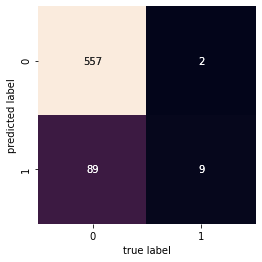

In [164]:
classes = ['0','1']
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score
import numpy as np
Ypred = ann.predict(Xtest)
Ypred_classes = Ypred

for i in range(len(Ypred)):
  if(Ypred[i]>0.5):
    Ypred_classes[i]=1
  else:
    Ypred_classes[i]=0
# Ypred_classes = [np.argmax(element) for element in Ypred]

print("Classification Report: \n", classification_report(Ytest, Ypred_classes))
print("-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/")
print("Confusion Matrix: \n", confusion_matrix(Ytest, Ypred_classes))
print("-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/")
print("Accuracy Score: \n", accuracy_score(Ytest, Ypred_classes))
print("-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/")
print("along x axis - true, along y axis - predicted")

import seaborn as sns

matrix = confusion_matrix(Ytest, Ypred_classes)
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');
from scipy.special import softmax
softmaxes_prediction = softmax(Ypred)
softmax_classes = softmaxes_prediction

for i in range(len(Ypred)):
  if(Ypred[i]>0.5):
    softmax_classes[i]=1
  else:
    softmax_classes[i]=0


print("Classification Report: \n", classification_report(Ytest, softmax_classes))
print("-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/")
print("Confusion Matrix: \n", confusion_matrix(Ytest, softmax_classes))
print("-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/")
print("Accuracy Score: \n", accuracy_score(Ytest, softmax_classes))
print("-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/")
print("along x axis - true, along y axis - predicted")

import seaborn as sns

matrix = confusion_matrix(Ytest, softmax_classes)
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');
def new_eval_metric_averaging(Ytest,Ypred_classes):
  final_matrix = np.zeros((2,2))
  final_matrix[0,0]=(matrix[0,0])/matrix[0,0]+matrix[0,1]
  final_matrix[0,1]=(matrix[0,1])/matrix[0,0]+matrix[0,1]
  final_matrix[1,0]=(matrix[1,0])/matrix[1,1]+matrix[1,0]
  final_matrix[1,1]=(matrix[1,1])/matrix[1,1]+matrix[1,0]
  return final_matrix.astype(int)
# final_matrix[0,0]=0
# final_matrix[0,1]=1
# final_matrix[1,0]=2
# final_matrix[1,1]=3
# final_matrix
print("-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/")
print("New Eval Metric Matrix Averaging: \n", new_eval_metric_averaging(Ytest, Ypred_classes))
